In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

In [2]:
from physical_formula_spinvdisk2 import disks_physical_formula_func as phys_eqn

In [3]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

In [4]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']

In [5]:
df_normalized_31.loc[:, 'GalpropNormMdisk'] = df_normalized_31.loc[:, 'GalpropNormMstar'] - df_normalized_31.loc[:, 'GalpropNormMbulge']

In [6]:
df_normalized_31.loc[:, 'DiskMstar_ratio']  = df_normalized_31.loc[:, 'GalpropNormMdisk']/df_normalized_31.loc[:, 'GalpropNormMstar']

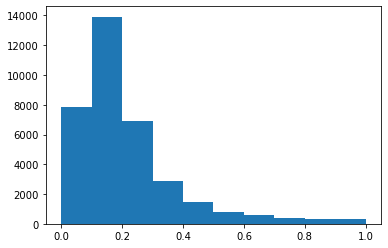

In [7]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.show()

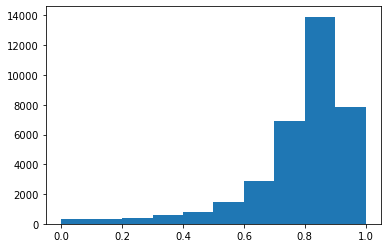

In [8]:
plt.hist(df_normalized_31['DiskMstar_ratio'])

plt.show()

#### Define the 6 morphology groups by increasing Mbulge/Mstar ratio

In [9]:
# 7,865 galaxies in df_1
df_1 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.10] 

# 13,921 galaxies in df_2
df_2 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.10) & (df_normalized_31.BulgeMstar_ratio <= 0.20)] 

# 6,880 galaxies in df_3
df_3 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.20) & (df_normalized_31.BulgeMstar_ratio <= 0.30)] 

# 2,858 galaxies in df_4
df_4 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.30) & (df_normalized_31.BulgeMstar_ratio <= 0.40)] 

# 1,444 galaxies in df_5
df_5 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.40) & (df_normalized_31.BulgeMstar_ratio <= 0.50)] 

# 2,422 galaxies in df_5
df_6 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']>0.50] 

#### equation for df_6 = ellipticals is different from the rest

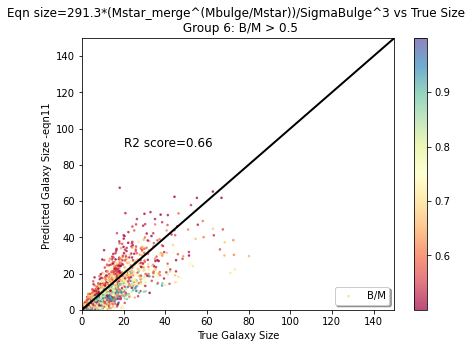

In [10]:
eqn11 = 291.3*np.abs(df_6.loc[:,'GalpropNormMstar_merge'])**df_6.loc[:,'BulgeMstar_ratio']/df_6.loc[:,'GalpropNormSigmaBulge']**3


r2_score_11=r2_score(df_6.loc[:, 'GalpropNormHalfRadius'], eqn11)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_6 = ax.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], eqn11,
            c = df_6.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M') #, vmin=-2, vmax=1.0)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('Eqn size=291.3*(Mstar_merge^(Mbulge/Mstar))/SigmaBulge^3 vs True Size \n Group 6: B/M > 0.5')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_complete.colorbar(fig_6, ax=ax)
# plt.savefig('Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

## Function size3(Mdisk/Mstar,spin,vdisk) = a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2

In [11]:
def mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar, a, c, spin_min):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is sspin_vdisk_diskmstar[0]
    # vdisk is spin_vdisk_diskmstar[1]
    # Mdisk/Mstar is spin_vdisk_diskmstar[2]
    
    spin_use = np.copy(spin_vdisk_diskmstar[0])
    vdisk = np.copy(spin_vdisk_diskmstar[1])
    diskmstar = np.copy (spin_vdisk_diskmstar[2])
    spin_use[spin_use < spin_min] = spin_min
    
    size = a*spin_use/vdisk**2 + c*diskmstar*spin_use/vdisk**2

    return size

In [14]:
def disks_physical_formula_func_version3 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
    Size_true = np.array(df.loc[:, 'GalpropNormHalfRadius'])
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
#     HalopropSpin = np.array(HalopropSpin)
    GalpropNormVdisk = np.array(df.loc[:, 'GalpropNormVdisk'])
#     GalpropNormVdisk = np.array(GalpropNormVdisk)
#   b) 
    spin_vdisk = [HalopropSpin, GalpropNormVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
    Mdisk = np.array (df.loc[:, 'GalpropNormMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropNormVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])
#   c)
# use first line when spin_min is variable
    popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true, p0=[1000, 500, 0.021])
# use second line when spin_min is fixed   
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true, p0=[1000, 500])


    size_func = mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar, *popt)
#   d) 
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) 
    df_spin_size = df.loc[:,['GalpropNormHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.021]
    actual_size= zz['GalpropNormHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true, size_func, marker='.', s=10, alpha=0.7, 
                c  = df.loc[:,'GalpropNormMdisk'],  
                cmap='Spectral',
#                 label=' colorbar: Mdisk/Mstar ratio \n fit: a=%5.3f \n c=%5.3f' % tuple(popt))
                label=' colorbar: Mdisk/Mstar ratio \n fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt))
    ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
    ax.set_xlim([0.0,150])
    ax.set_ylim([0.0,150])
    ax.text(10, 90, 'R2 score=' + '{:.2f}'.format(r2_score_df), size=12)
    ax.text(10, 85, 'R2_lowspin_gals=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
    ax.set_title('Eqn size= a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2 vs True Size \n {} '.format(group))
    ax.set_ylabel('Size as predicted by spin/vdisk^2 function')
    ax.set_xlabel('True Size')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
    fig_prediction.tight_layout()
    # plt.savefig('BulgierDisks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar, popt, pcov, size_func, fig_prediction, r2_score_df, r2_score_lowspin

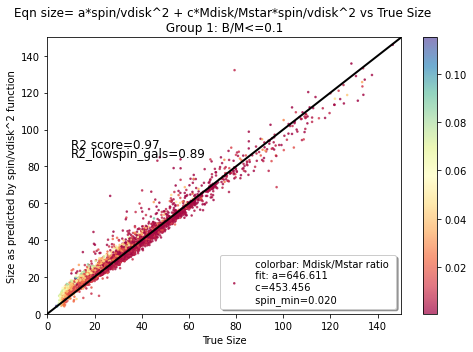

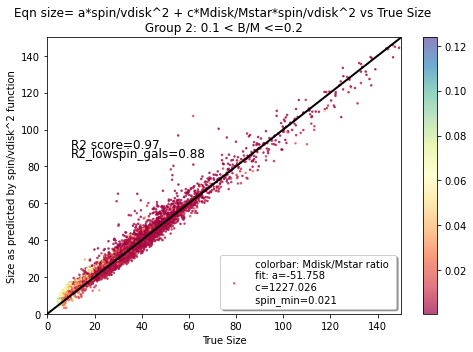

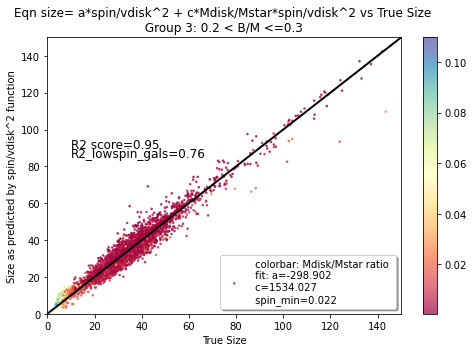

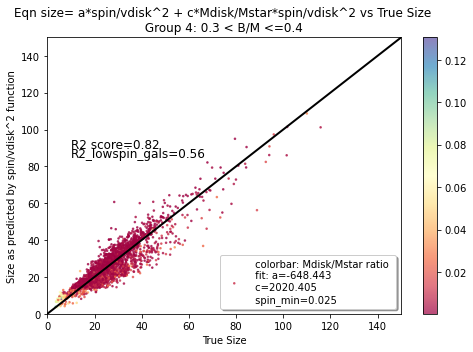

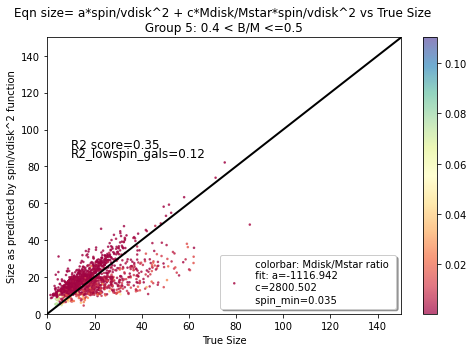

In [15]:
results_df_1 = disks_physical_formula_func_version3(df_1, group = 'Group 1: B/M<=0.1')
popt1 = results_df_1[1]

results_df_2 = disks_physical_formula_func_version3(df_2, group = 'Group 2: 0.1 < B/M <=0.2')
popt2 = results_df_2[1]

results_df_3 = disks_physical_formula_func_version3(df_3, group = 'Group 3: 0.2 < B/M <=0.3')
popt3 = results_df_3[1]

results_df_4 = disks_physical_formula_func_version3(df_4, group = 'Group 4: 0.3 < B/M <=0.4')
popt4 = results_df_4[1]

results_df_5 = disks_physical_formula_func_version3(df_5, group = 'Group 5: 0.4 < B/M <=0.5')
popt5 = results_df_5[1]

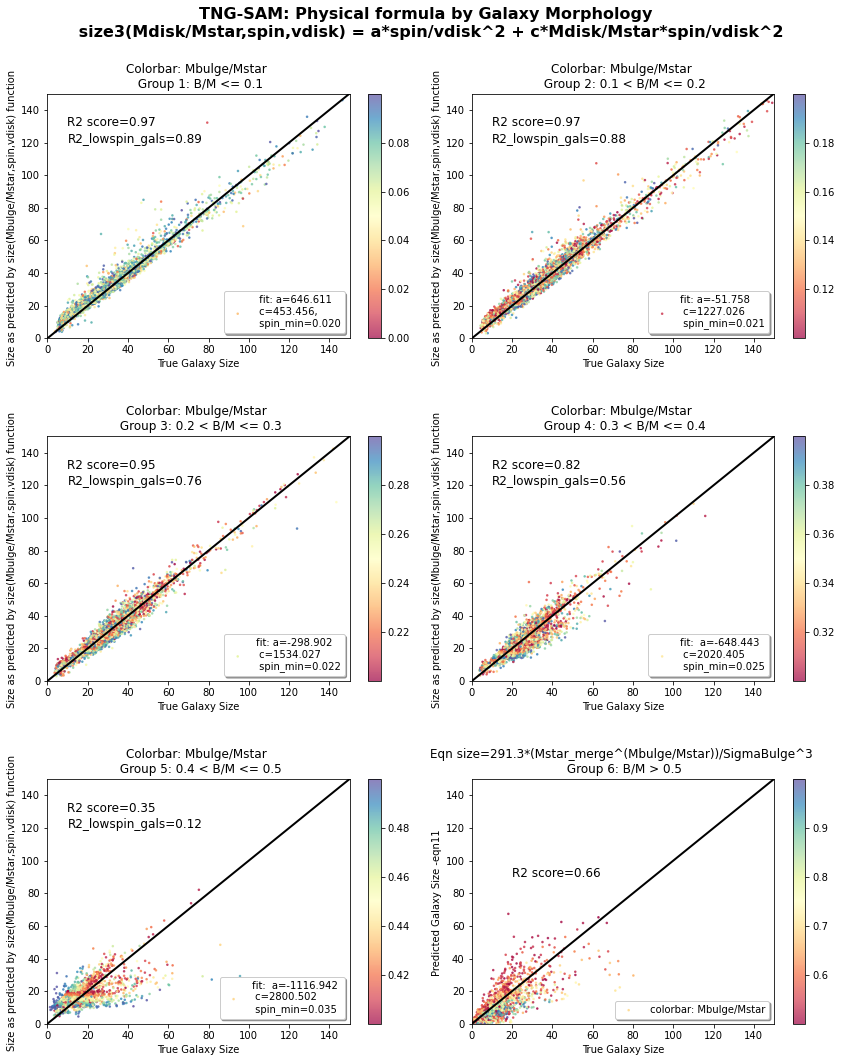

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Physical formula by Galaxy Morphology \n size3(Mdisk/Mstar,spin,vdisk) = a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], results_df_1[3],
            c = df_1.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' fit: a=%5.3f \n c=%5.3f, \n spin_min=%5.3f' % tuple(popt1)) #,label= label, vmin=-2, vmax=1.0)
ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], results_df_2[3],
            c = df_2.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt2)) #,label= label, vmin=-2, vmax=1.0)
ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_2, ax=ax2)

fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], results_df_3[3],
            c = df_3.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt3)) #,label= label, vmin=-2, vmax=1.0)
ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_3, ax=ax3)

fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], results_df_4[3],
            c = df_4.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt4)) #,label= label, vmin=-2, vmax=1.0)
ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_4, ax=ax4)

fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], results_df_5[3],
            c = df_5.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt5)) #,label= label, vmin=-2, vmax=1.0)
ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_5, ax=ax5)


fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], eqn11,
            c = df_6.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' colorbar: Mbulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Eqn size=291.3*(Mstar_merge^(Mbulge/Mstar))/SigmaBulge^3 \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.90, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_physformula_size3_diskmstar_spinvdisk2_by_Galaxy_Morphology.jpeg", dpi=500)
plt.show()

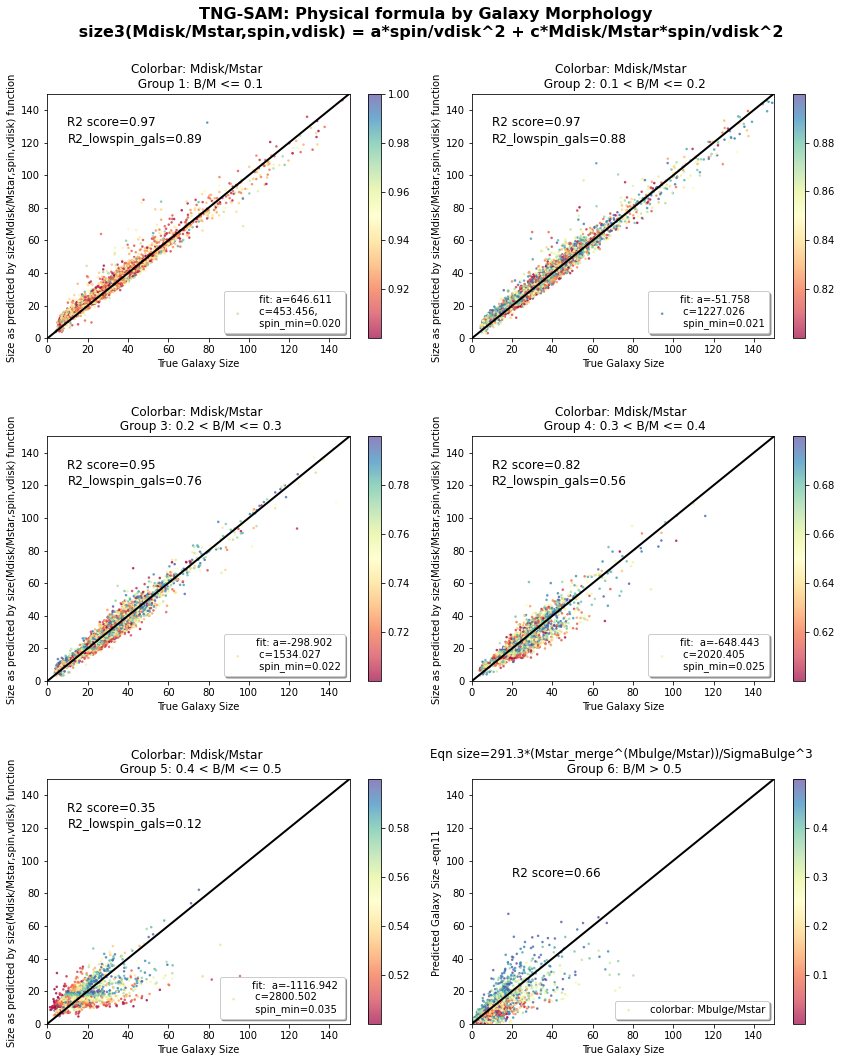

In [28]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Physical formula by Galaxy Morphology \n size3(Mdisk/Mstar,spin,vdisk) = a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], results_df_1[3],
            c = df_1.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' fit: a=%5.3f \n c=%5.3f, \n spin_min=%5.3f' % tuple(popt1)) #,label= label, vmin=-2, vmax=1.0)
ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mdisk/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], results_df_2[3],
            c = df_2.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt2)) #,label= label, vmin=-2, vmax=1.0)
ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mdisk/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_2, ax=ax2)

fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], results_df_3[3],
            c = df_3.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt3)) #,label= label, vmin=-2, vmax=1.0)
ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mdisk/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_3, ax=ax3)

fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], results_df_4[3],
            c = df_4.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt4)) #,label= label, vmin=-2, vmax=1.0)
ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mdisk/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_4, ax=ax4)

fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], results_df_5[3],
            c = df_5.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt5)) #,label= label, vmin=-2, vmax=1.0)
ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mdisk/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_5, ax=ax5)


fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], eqn11,
            c = df_6.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' colorbar: Mbulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Eqn size=291.3*(Mstar_merge^(Mbulge/Mstar))/SigmaBulge^3 \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.90, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_physformula_size3_diskmstar_spinvdisk2_by_Galaxy_Morphology_mdiskratiocolorbar.jpeg", dpi=500)
plt.show()

### popt trend over galaxy morphology bins for size1

In [18]:
mean_BulgeMstar_per_bin = [np.mean(df_1.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_2.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_3.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_4.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_5.loc[:, 'BulgeMstar_ratio'])
                          ]

mean_BulgeMstar_per_bin = np.array(mean_BulgeMstar_per_bin)

In [19]:
mean_DiskMstar_per_bin = [np.mean(df_1.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_2.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_3.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_4.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_5.loc[:, 'DiskMstar_ratio'])
                          ]

mean_DiskMstar_per_bin = np.array(mean_DiskMstar_per_bin)

### popt trend over galaxy morphology bins for size2

In [20]:
# popt = [a, c, spin_min]
popt1

array([6.46611394e+02, 4.53456148e+02, 2.00800195e-02])

In [21]:
a_values_per_bin = [popt1[0], popt2[0], popt3[0], popt4[0], popt5[0]]

a_values_per_bin = np.array(a_values_per_bin)

c_values_per_bin = [popt1[1], popt2[1], popt3[1], popt4[1], popt5[1]]

c_values_per_bin = np.array(c_values_per_bin)


In [22]:
# spin_min_values_per_bin = [0.021, 0.021, 0.021, 0.021, 0.021]

spin_min_values_per_bin = [popt1[2], popt2[2], popt3[2], popt4[2], popt5[2]]

spin_min_values_per_bin = np.array (spin_min_values_per_bin)

spin_min_values_per_bin

array([0.02008002, 0.02054891, 0.02184723, 0.02450667, 0.03519946])

In [23]:
a_values_per_bin

array([  646.61139405,   -51.75751084,  -298.90193519,  -648.44318207,
       -1116.94169406])

In [24]:
a_values_per_bin[0:4]

array([ 646.61139405,  -51.75751084, -298.90193519, -648.44318207])

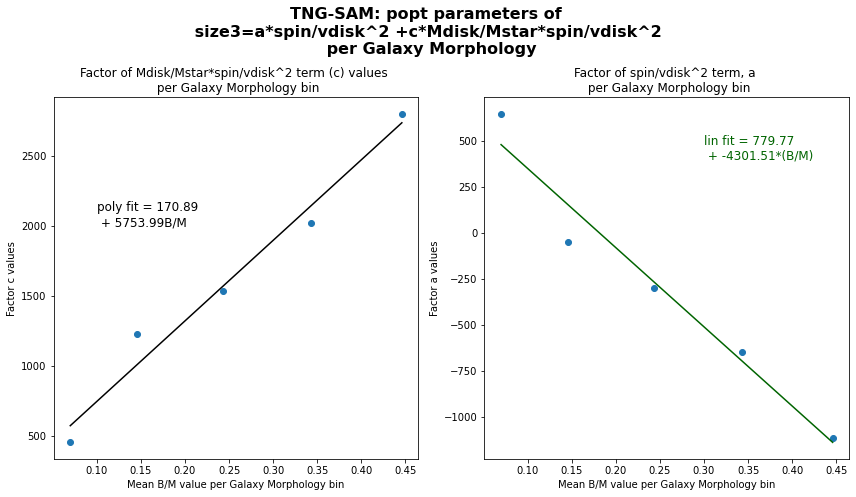

In [25]:
fig,[ax1,ax2]=plt.subplots(nrows=1,ncols=2,figsize=(12,7))
fig.suptitle('TNG-SAM: popt parameters of \n size3=a*spin/vdisk^2 +c*Mdisk/Mstar*spin/vdisk^2 \n per Galaxy Morphology', fontsize=16, fontweight='bold')

b1_poly, a1_poly = np.polyfit(mean_BulgeMstar_per_bin, c_values_per_bin , 1)

ax1.scatter(mean_BulgeMstar_per_bin, c_values_per_bin)
ax1.set_title('Factor of Mdisk/Mstar*spin/vdisk^2 term (c) values \n per Galaxy Morphology bin')
ax1.set_xlabel('Mean B/M value per Galaxy Morphology bin')
ax1.set_ylabel('Factor c values')
#add line of best fit to plot
ax1.plot(mean_BulgeMstar_per_bin, b1_poly*mean_BulgeMstar_per_bin+a1_poly, color='black') 
#add fitted regression equation to plot
ax1.text(0.1, 2000, 'poly fit = ' + '{:.2f}'.format(a1_poly) + '\n + {:.2f}'.format(b1_poly) + 'B/M', size=12)
#ax1.legend(loc='upper right')


b3_poly_1, a3_poly_1 = np.polyfit(mean_BulgeMstar_per_bin, a_values_per_bin , 1)
# c3_poly, b3_poly, a3_poly = np.polyfit(mean_BulgeMstar_per_bin, a_values_per_bin , 2)


ax2.scatter(mean_BulgeMstar_per_bin, a_values_per_bin)
ax2.set_title('Factor of spin/vdisk^2 term, a \n per Galaxy Morphology bin')
ax2.set_xlabel('Mean B/M value per Galaxy Morphology bin')
ax2.set_ylabel('Factor a values')
#add line of best fit to plot
# ax2.plot(mean_BulgeMstar_per_bin,c3_poly*mean_BulgeMstar_per_bin**2 + b3_poly*mean_BulgeMstar_per_bin+a3_poly, color='black') 
ax2.plot(mean_BulgeMstar_per_bin,b3_poly_1*mean_BulgeMstar_per_bin+a3_poly_1, color='darkgreen') 

#add fitted regression equation to plot
ax2.text(0.3, 400, 'lin fit = ' + '{:.2f}'.format(a3_poly_1) + '\n + {:.2f}'.format(b3_poly_1) + '*(B/M)', size=12, color='darkgreen')
# ax2.text(0.3, 500, 'sq fit = ' + '{:.2f}'.format(a3_poly) + '\n + {:.2f}'.format(b3_poly) + 'B/M'  + '\n + {:.2f}'.format(c3_poly) + 'B/M^2', size=12)


fig.tight_layout()
fig.subplots_adjust(top=0.8)
# plt.savefig("TNG-SAM_popt_size3_per_Galaxy_Morphology.jpeg", dpi=500)
plt.show()

## Relative error for size2 function

In [23]:
# relative error = (predicted size - true size)/ true size
relative_error_1 = (results_df_1[3] - df_1.loc[:, 'GalpropNormHalfRadius'])/df_1.loc[:, 'GalpropNormHalfRadius']

In [24]:
df_1_relerr = df_1.loc[:]

df_1_relerr.shape

df_1_relerr['Relative Error'] = relative_error_1

df_1_relerr.shape

# df_1_relerr_sample = df_1_relerr.sample(n = 1000, random_state = 2022)
df_1_relerr_sample = df_1_relerr.sample(n = 1000)


df_1_relerr_sample.columns.to_list

df_1_relerr_sample = df_1_relerr_sample.loc[:,['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormMHI', 'HalopropC_nfw', 'GalpropNormMbulge',
                              'GalpropNormMH2', 'GalpropNormMstar', 'BulgeMstar_ratio', 
                              'GalpropNormSigmaBulge','Relative Error']]
# bulgy disks imp features below
# df_1_relerr_sample = df_1_relerr_sample.loc[:, ['HalopropSpin',                                                 
#                             'GalpropNormVdisk', 'GalpropNormSigmaBulge', 'HalopropC_nfw', 'GalpropNormMcold',
#                             'GalpropTmerger', 'GalpropOutflowRate_Metal', 'HalopropNormMstar_diffuse',
#                             'GalpropNormMbulge', 'GalpropTmerger_major', 'HalopropMetal_ejected',
#                              'GalpropNormMstar', 'GalpropNormMHI', 'GalpropNormHalfRadius',
#                              'BulgeMstar_ratio', 'Relative Error']]

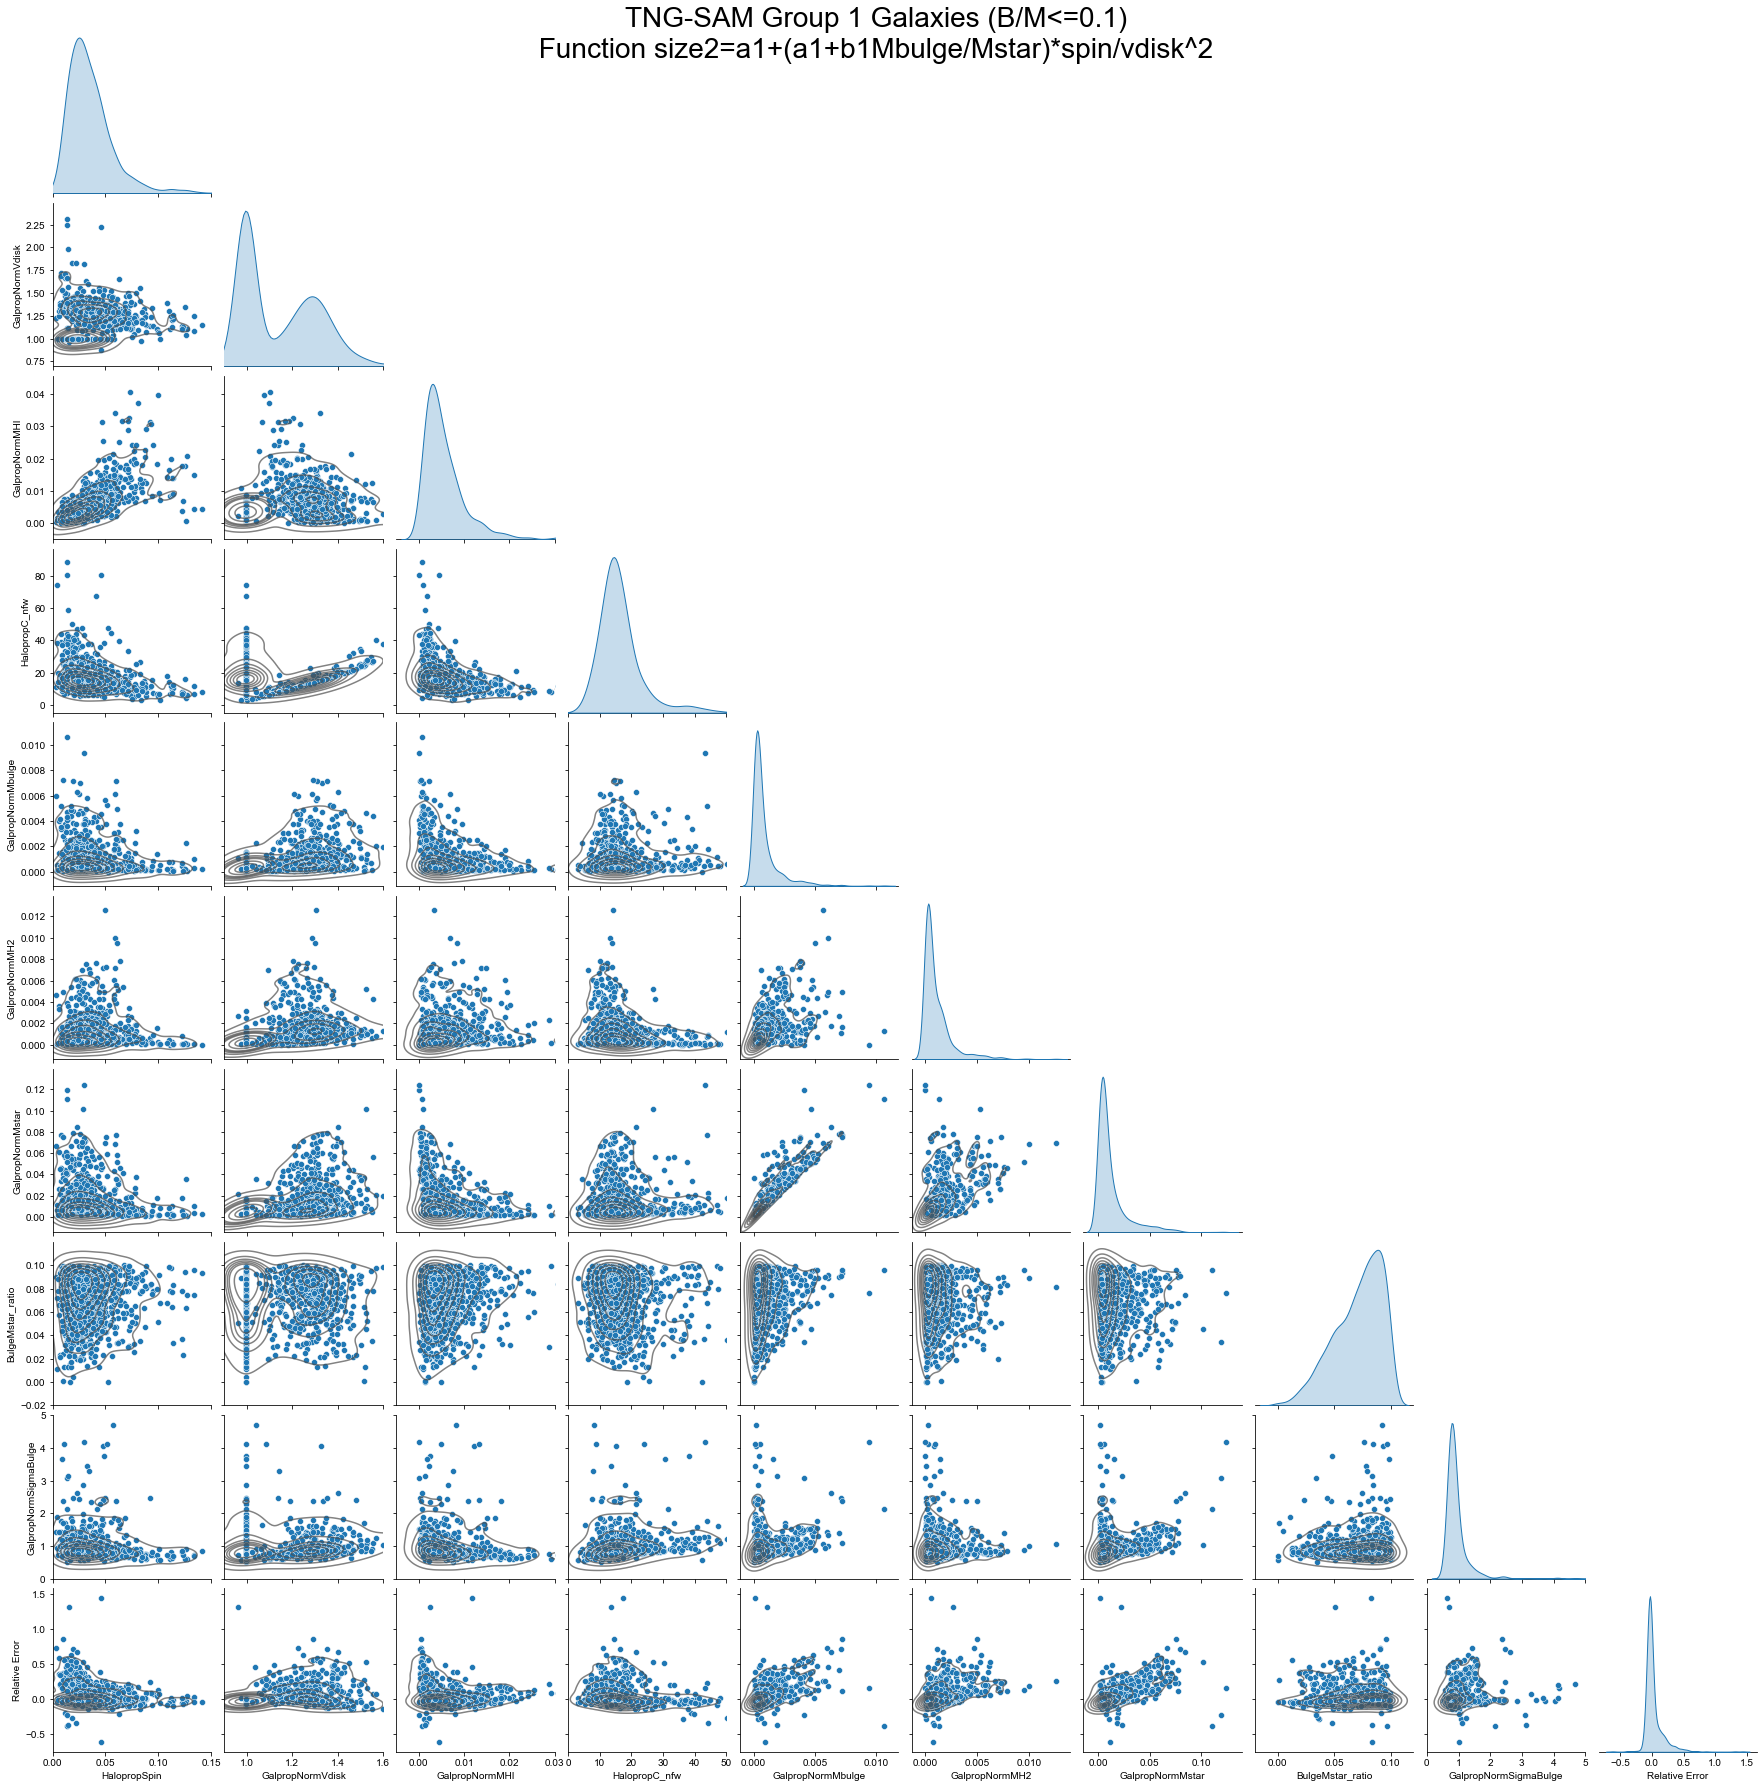

In [25]:
pairplot_1=sns.pairplot(df_1_relerr_sample, diag_kind='kde', corner = True)
pairplot_1.fig.suptitle("TNG-SAM Group 1 Galaxies (B/M<=0.1) \n Function size2=a1+(a1+b1Mbulge/Mstar)*spin/vdisk^2  ", y=1.0, fontsize=28) # y= some height>1

pairplot_1.map_lower(sns.kdeplot, levels=8, color=".3", alpha=0.7)

pairplot_1.axes[0,0].set_xlim([0.0, 0.15]) # spin
pairplot_1.axes[1,1].set_xlim([0.9,1.6]) # vdisk
pairplot_1.axes[2,2].set_xlim([-0.005,0.03]) # NormMHI
pairplot_1.axes[3,3].set_xlim([0.0,50]) # C_nfw
# pairplot_1.axes[4,4].set_xlim([0.0,0.075]) # Mcold
# pairplot_1.axes[5,5].set_xlim([0.0,30]) # Tmerger
# pairplot_1.axes[6,6].set_xlim([0.0,10]) # OutflowRate_Metal
# pairplot_1.axes[7,7].set_xlim([0.0,0.0005]) # Mstar_diffuse
# pairplot_1.axes[8,8].set_xlim([0.0,0.015]) # Mbulge
pairplot_1.axes[8,8].set_xlim([0.0,5]) # SigmaBulge
pairplot_1.axes[8,8].set_ylim([0.0,5]) # SigmaBulge



# pairplot_1.axes[10,10].set_xlim([0.0,30]) # HalopropMetal_ejected
# pairplot_1.axes[11,11].set_xlim([0.0,0.06]) # NormMstar

# pairplot_1.axes[13,13].set_xlim([0.0,80]) # NormHalfRadius


sns.set_style("ticks",
{"xtick.major.size":8, "ytick.major.size":8})

# plt.savefig("Group1_pairplot_size2func_bmstarspinvdisk2.pdf", dpi=500)




In [26]:
# relative error = (predicted size - true size)/ true size
relative_error_2 = (results_df_2[3] - df_2.loc[:, 'GalpropNormHalfRadius'])/df_2.loc[:, 'GalpropNormHalfRadius']

In [30]:
df_2_relerr = df_2.loc[:]

df_2_relerr.shape

df_2_relerr['Relative Error'] = relative_error_2

df_2_relerr.shape

# df_1_relerr_sample = df_1_relerr.sample(n = 1000, random_state = 2022)
df_2_relerr_sample = df_2_relerr.sample(n = 1000)


df_2_relerr_sample.columns.to_list

df_2_relerr_sample = df_2_relerr_sample.loc[:,['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormMHI', 'HalopropC_nfw', 'GalpropNormMbulge',
                              'GalpropNormMH2', 'GalpropNormMstar', 'BulgeMstar_ratio',
                              'GalpropTmerger_major', 'GalpropOutflowRate_Metal', 'HalopropNormMstar_diffuse', 
                              'GalpropNormSigmaBulge','Relative Error']]

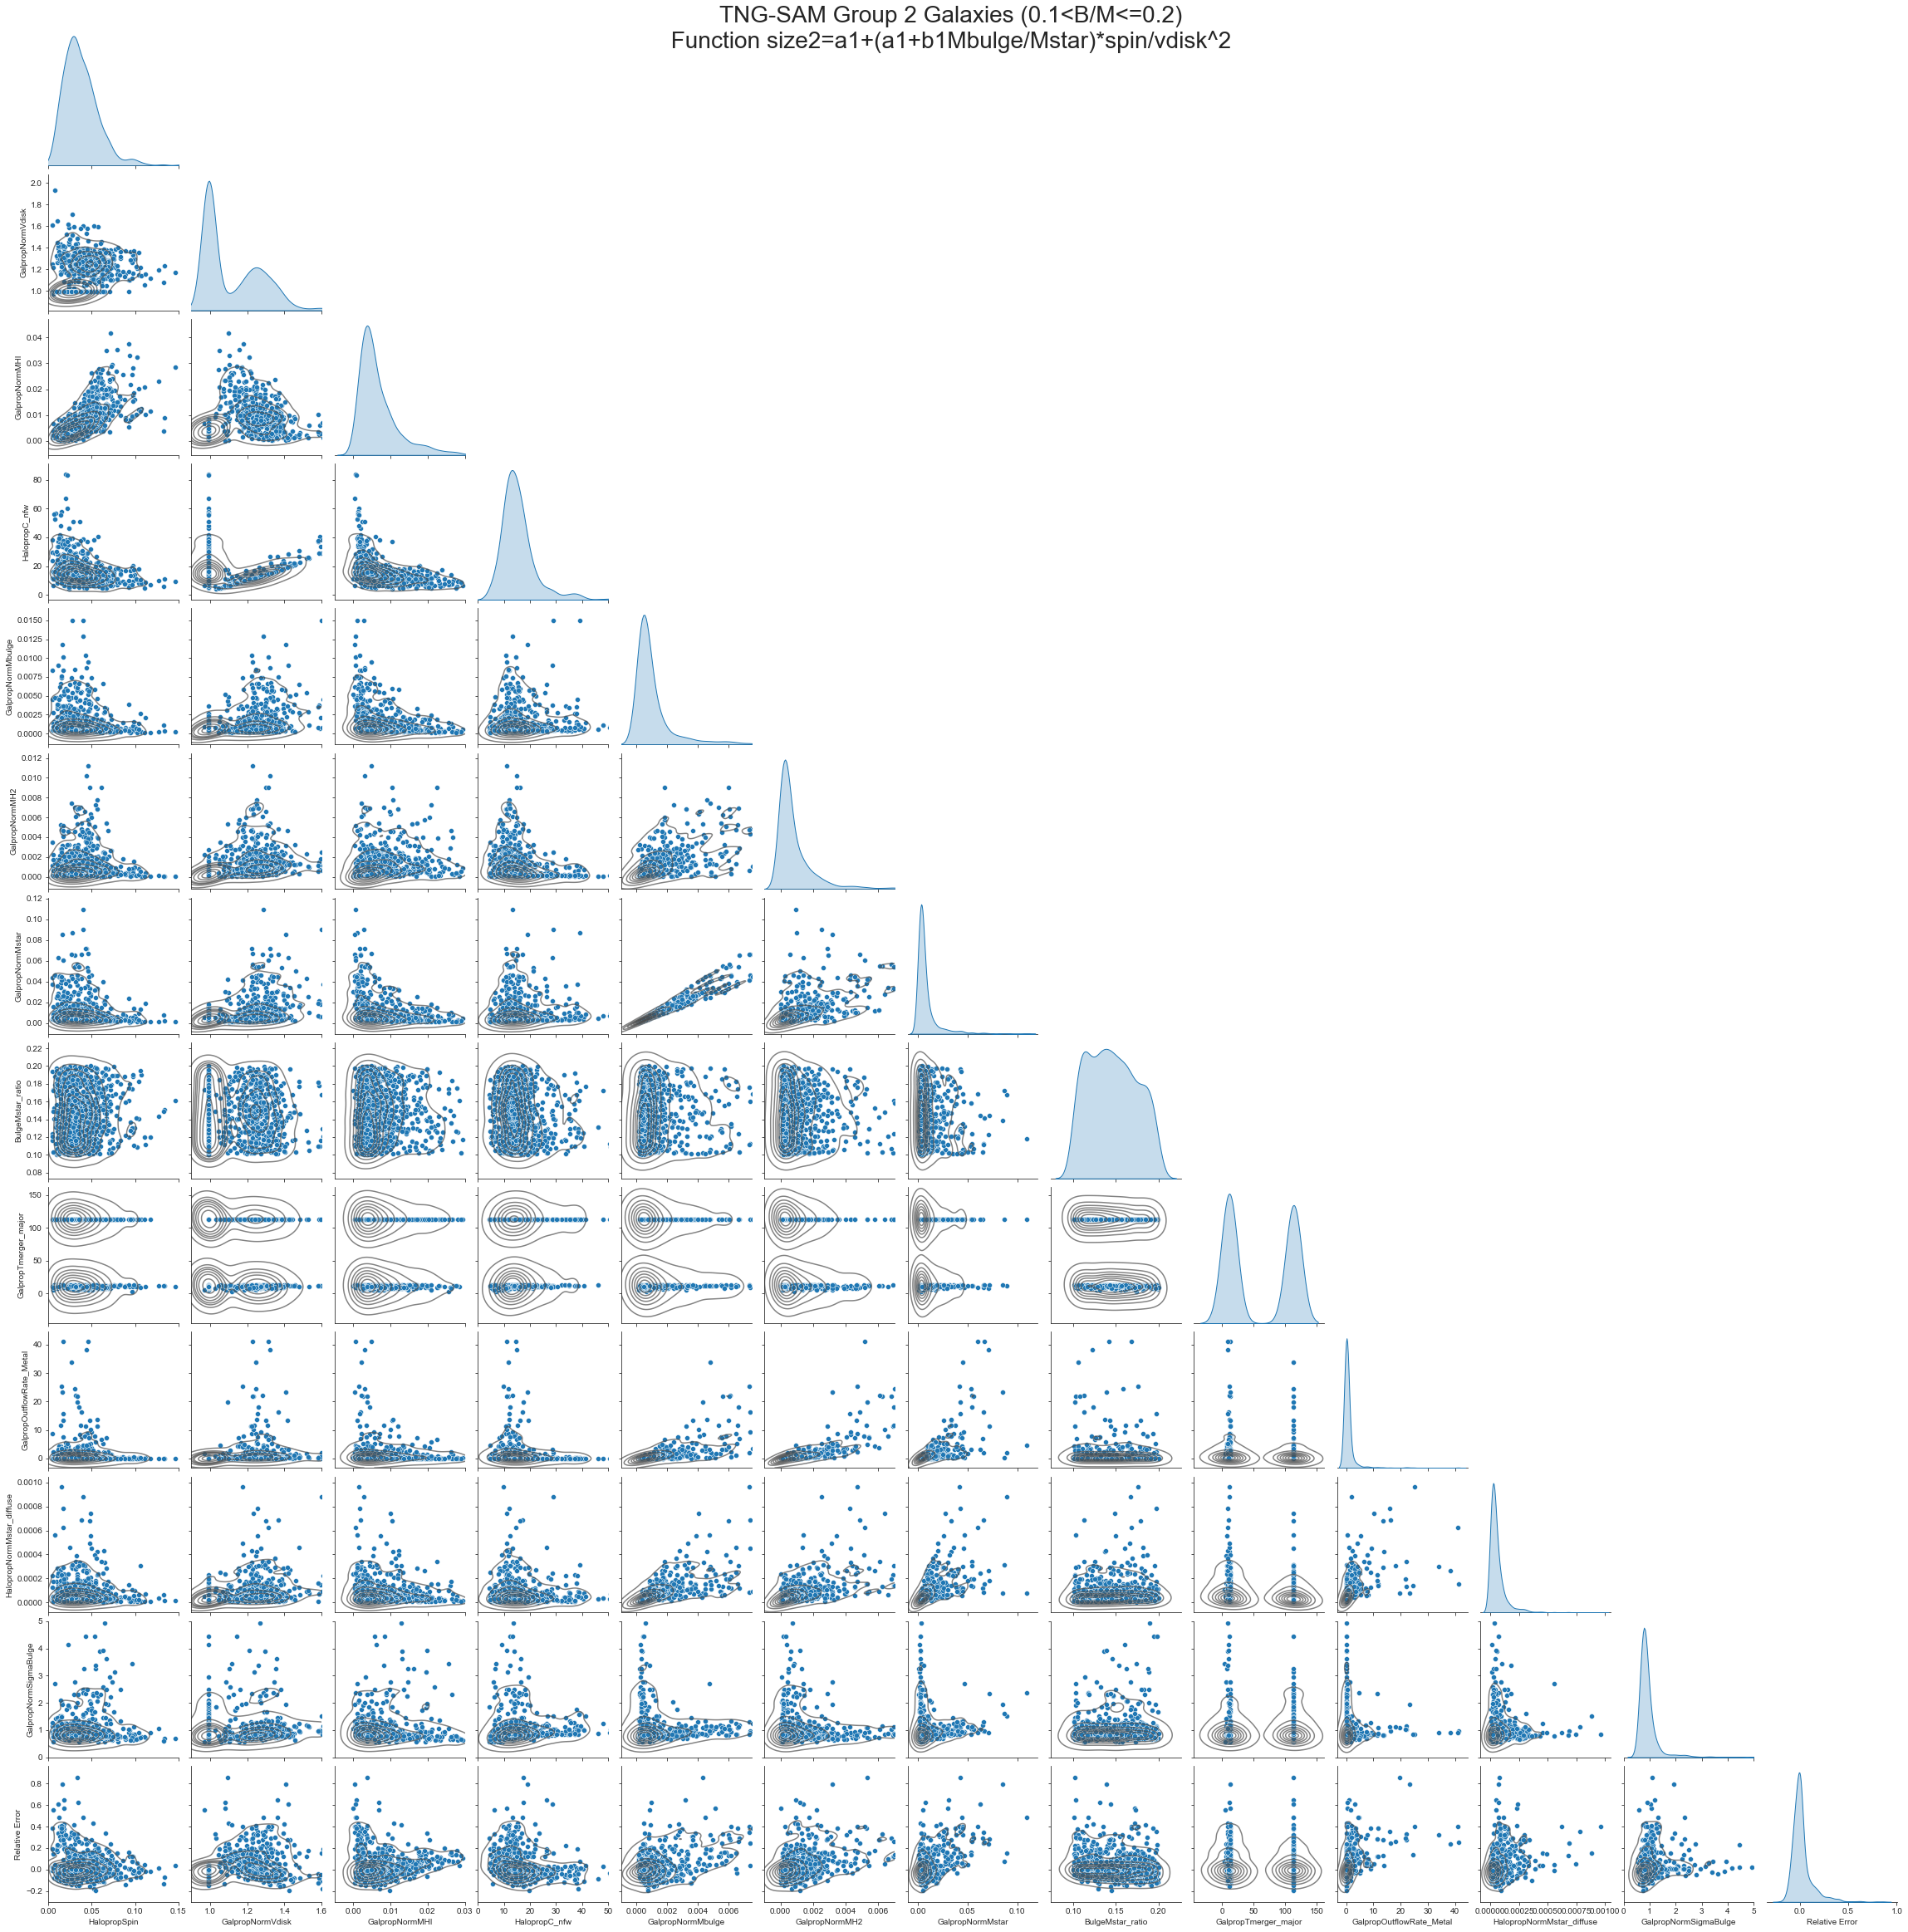

In [31]:
pairplot_2=sns.pairplot(df_2_relerr_sample, diag_kind='kde', corner = True)
pairplot_2.fig.suptitle("TNG-SAM Group 2 Galaxies (0.1<B/M<=0.2) \n Function size2=a1+(a1+b1Mbulge/Mstar)*spin/vdisk^2  ", y=1.0, fontsize=28) # y= some height>1

pairplot_2.map_lower(sns.kdeplot, levels=8, color=".3", alpha=0.7)

pairplot_2.axes[0,0].set_xlim([0.0, 0.15]) # spin
pairplot_2.axes[1,1].set_xlim([0.9,1.6]) # vdisk
pairplot_2.axes[2,2].set_xlim([-0.005,0.03]) # NormMHI
pairplot_2.axes[3,3].set_xlim([0.0,50]) # C_nfw
pairplot_2.axes[4,4].set_xlim([-0.001,0.0075]) # NormMbulge
pairplot_2.axes[5,5].set_xlim([-0.001,0.007]) # NormMHII


# pairplot_2.axes[5,5].set_xlim([0.0,30]) # Tmerger
# pairplot_2.axes[6,6].set_xlim([0.0,10]) # OutflowRate_Metal
# pairplot_2.axes[7,7].set_xlim([0.0,0.0005]) # Mstar_diffuse
# pairplot_2.axes[8,8].set_xlim([0.0,0.015]) # Mbulge
pairplot_2.axes[11,11].set_xlim([0.0,5]) # SigmaBulge
pairplot_2.axes[11,11].set_ylim([0.0,5]) # SigmaBulge



# pairplot_2.axes[10,10].set_xlim([0.0,30]) # HalopropMetal_ejected
# pairplot_2.axes[11,11].set_xlim([0.0,0.06]) # NormMstar

# pairplot_2.axes[13,13].set_xlim([0.0,80]) # NormHalfRadius


sns.set_style("ticks",
{"xtick.major.size":8, "ytick.major.size":8})

# plt.savefig("Group2_pairplot_size2func_bmstarspinvdisk2.pdf", dpi=500)





## Radius vs Spin in the Original (Raw) Dataset

### Is the hockey stick shape of the spin-size plot physical or is it a typo coming from calculating the halfmass radius?

In [29]:
# original (raw) dataset, not normalized, no halfmass radius column present
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv')

In [32]:
df_log_mass_filtered_v5.head(2)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,...,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction
0,130136.002554,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,...,9.653455,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19
1,541275.017895,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,...,11.109008,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01


In [35]:
df_log_mass_filtered_v5.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRedshift',
 'GalpropRfric',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'GalpropX',
 'GalpropVx',
 'GalpropY',
 'GalpropVy',
 'GalpropZ',
 'GalpropVz',
 'HalopropC_nfw',
 'HalopropMaccdot_metal',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMaccdot_reaccreate_metal',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMdot_eject',
 'HalopropMdot_eject_metal',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMst

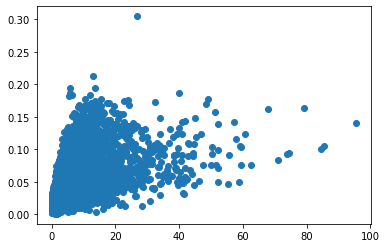

In [36]:
rbulge_raw = df_log_mass_filtered_v5.loc[:, 'GalpropRbulge'] # 3D half-mass radius of bulge

rdisk_raw = df_log_mass_filtered_v5.loc[:, 'GalpropRdisk'] # 3D half-mass radius of disk

rhalo_raw = df_log_mass_filtered_v5.loc[:, 'GalpropRhalo'] # halo virial radius

spin_raw = df_log_mass_filtered_v5.loc[:, 'HalopropSpin']


plt.scatter(rdisk_raw, spin_raw)
plt.show()